In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

In [3]:
def compute_pos(xticks, width, i, models):
    index = np.arange(len(xticks))
    n = len(models)
    correction = i-0.5*(n-1)
    return index + width*correction

def present_height(ax, bar):
    for rect in bar:
        height = rect.get_height()
        posx = rect.get_x()+rect.get_width()*0.5
        posy = height*1.01
        ax.text(posx, posy, '%.4f' % height, rotation=90, 
                ha='center', va='bottom', fontsize=15, zorder=3)

In [4]:
def plot(xticks, data, ylim=None, figsize=(25, 10)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    colors = ['salmon', 'orange', 'cadetblue', 'skyblue', 'plum']
    width = 0.15
    for i, model in enumerate(data.keys()):
        pos = compute_pos(xticks, width, i, data.keys())
        bar = ax.bar(pos, data[model], width=width*0.95, label=model, color=colors[i])
        present_height(ax, bar)

    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks, fontsize=15)	

    if not ylim is None:
        plt.ylim(ymax=ylim)
    ax.set_ylabel('False Negative Rate', fontsize=20)
    ax.legend(loc='upper right', shadow=True, ncol=1, fontsize=15)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
    plt.tight_layout()
    return fig, ax

In [13]:
%matplotlib inline
attacks = ['DoS', 'Fuzzy', 'Gear', 'RPM']
data_by_bs = {
    '512': [ 0.0101, 0.0395, 0.0549, 0.0570
],
    '1024': [ 0.0221, 0.0589, 0.0549, 0.0517
],
    '2048': [ 0.0175, 0.0636, 0.0602, 0.0556
],
    '4096': [ 0.0405, 0.0961, 0.0576, 0.0594
] 
}

In [14]:
data_by_attack = np.array([v for _, v in data_by_bs.items()]).T
data_by_attack = {k: v for k, v in zip(attacks, data_by_attack)}
data_by_attack

{'DoS': array([0.0101, 0.0221, 0.0175, 0.0405]),
 'Fuzzy': array([0.0395, 0.0589, 0.0636, 0.0961]),
 'Gear': array([0.0549, 0.0549, 0.0602, 0.0576]),
 'RPM': array([0.057 , 0.0517, 0.0556, 0.0594])}

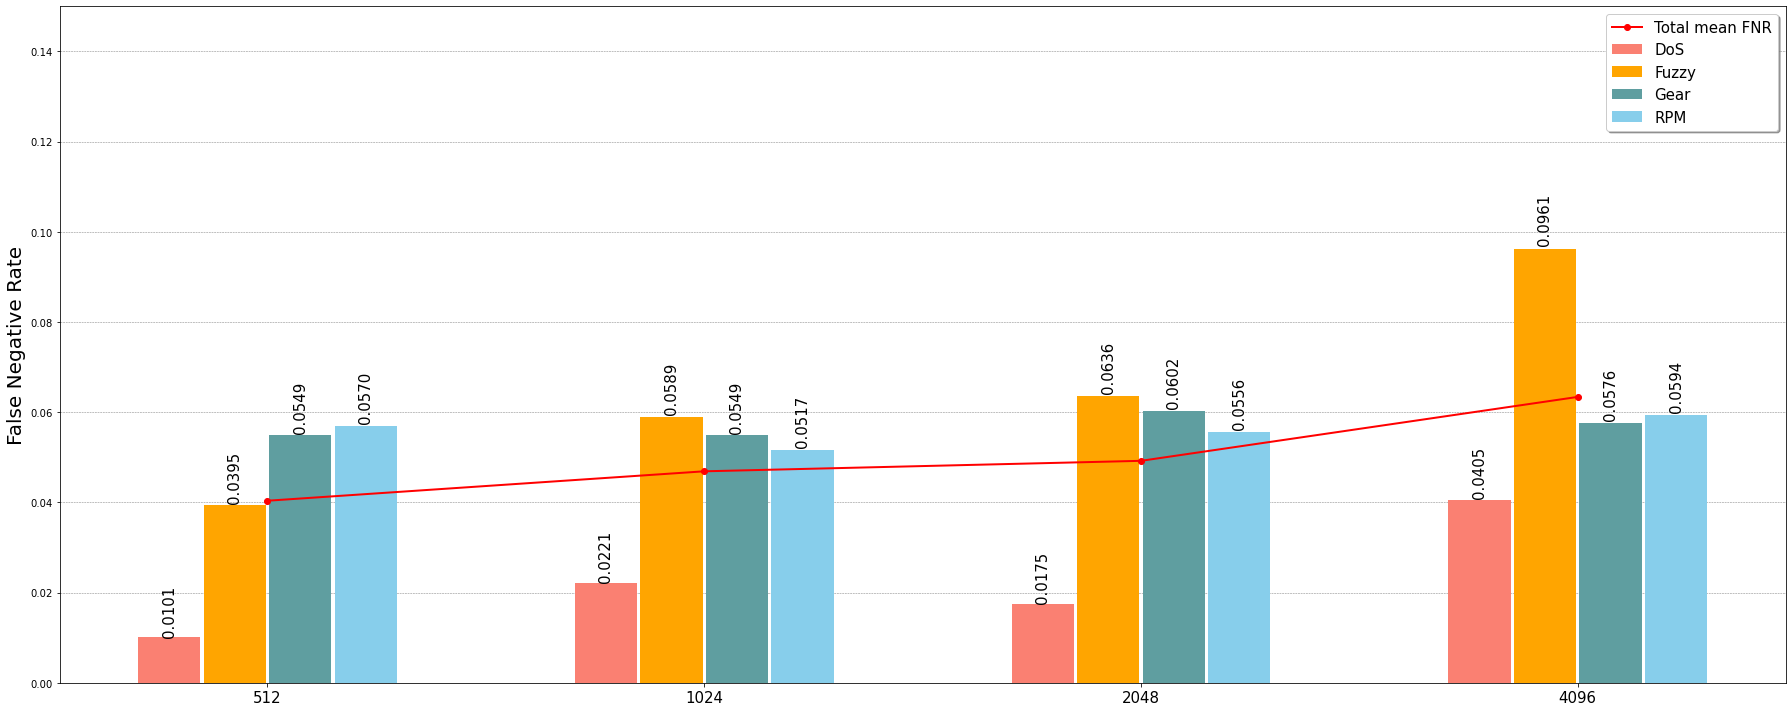

In [18]:
xticks = ['512', '1024', '2048', '4096']
fig, ax = plot(xticks, data_by_attack, ylim=0.15)
values = [np.mean(v) for v in data_by_bs.values()]
ax.plot(xticks, values, color='red', marker='o', linewidth=2, zorder=1,
       label='Total mean FNR')
ax.legend(loc='upper right', shadow=True, ncol=1, fontsize=15)
plt.savefig('hyperparams.png', dpi=300)

In [57]:
# KIA
train = np.array([
    [0.0016, 0.1028, 0.2700, 0.0514],
    [0.1616, 0.0800, 0.4927, 0.5231],
    [0.0008, 0.0114, 0.0237, 0.0140],
])

val = np.array([
    [0.0306, 0.1243, 0.4696, 0.3159], # Random
    [0.2220, 0.0622, 0.6630, 0.7516], # CE
    [0.0000, 0.0089, 0.0552, 0.0545] # Supcon
])

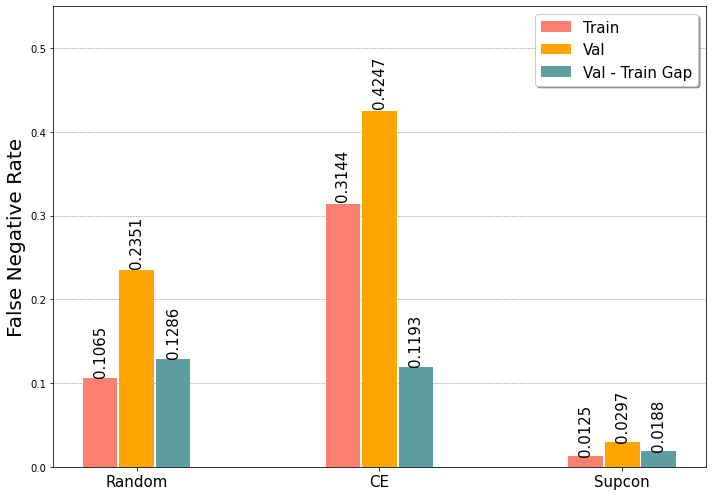

In [58]:
xticks = ['Random', 'CE', 'Supcon']

data = {
    'Train': train.mean(axis=1),
    'Val': val.mean(axis=1),
    'Val - Train Gap': abs(val-train).mean(axis=1),
}

plot(xticks, data, ylim=0.55, figsize=(10, 7))
plt.savefig('../figures/transfer_KIA.png', dpi=300)

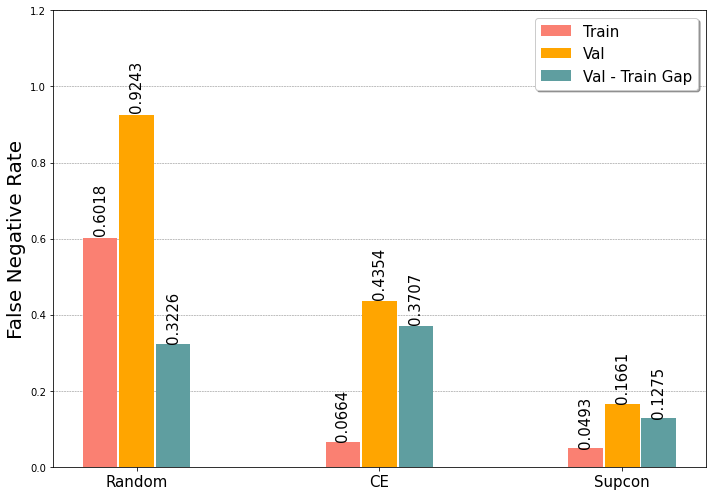

In [46]:
# Chevrolet
train = np.array([
    [0.1984, 0.1256, 1.8153, 0.2677],
    [0.0697, 0.0503, 0.0626, 0.0831],
    [0.1215, 0.0201, 0.0000, 0.0554],
])

val = np.array([
    [0.2543, 0.1758, 2.9872, 0.2799],
    [0.1084, 0.0469, 1.4572, 0.1292],
    [0.1126, 0.0352, 0.4736, 0.0431],
])
xticks = ['Random', 'CE', 'Supcon']

data = {
    'Train': train.mean(axis=1),
    'Val': val.mean(axis=1),
    'Val - Train Gap': abs(val-train).mean(axis=1)
}

plot(xticks, data, ylim=1.2, figsize=(10, 7))
plt.savefig('../figures/transfer_Chev.png', dpi=300)

In [47]:
import torch
from dataset import CANDataset

In [50]:
data_dir = '../../Data/Survival/TFrecord_KIA_w29_s10/1/'
val_dataset = CANDataset(data_dir, 
                             window_size = 29,
                            is_train=False)
val_loader = torch.utils.data.DataLoader(
                val_dataset, batch_size=256, 
                num_workers=8, pin_memory=True)

In [55]:
cnt = {}
for _, label in val_loader:
    key, value = np.unique(label, return_counts=True)
    for k, v in zip(key, value):
        if k not in cnt:
            cnt[k] = 0
        else:
            cnt[k] += v

In [56]:
cnt

{1: 1996, 0: 10400, 2: 3445, 3: 1737}